#IMPORTING DATASET FROM AMAZON S3 AND REQUIRED PACKAGES

In [ ]:
%%bash

pip install pyspark 
pip install -U kaleido
wget https://bdadata.s3.amazonaws.com/rideshare_kaggle.csv
wget https://bdadata.s3.amazonaws.com/Uber.csv


  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=2a236cab1b78e3a1efcb9ef7bd2655892b622ee83bba0c7c330adde3d43e0598
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


--2022-05-05 23:39:29--  https://bdadata.s3.amazonaws.com/rideshare_kaggle.csv
Resolving bdadata.s3.amazonaws.com (bdadata.s3.amazonaws.com)... 52.217.138.81
Connecting to bdadata.s3.amazonaws.com (bdadata.s3.amazonaws.com)|52.217.138.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 367383382 (350M) [text/csv]
Saving to: ‘rideshare_kaggle.csv’

     0K .......... .......... .......... .......... ..........  0% 1.27M 4m36s
    50K .......... .......... .......... .......... ..........  0% 2.44M 3m30s
   100K .......... .......... .......... .......... ..........  0% 74.4M 2m21s
   150K .......... .......... .......... .......... ..........  0% 69.5M 1m47s
   200K .......... .......... .......... .......... ..........  0% 2.66M 1m52s
   250K .......... .......... .......... .......... ..........  0% 64.0M 94s
   300K .......... .......... .......... .......... ..........  0% 65.4M 82s
   350K .......... .......... .......... .......... ..........  0% 71.9M 72s

In [ ]:
#import the required libraries
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import FloatType
from shapely.geometry import Point,Polygon
import descartes
from pyspark.ml import Pipeline
from pyspark.ml import feature
import plotly.express as px
from pyspark.ml.stat import Correlation



#create and initialize spark session and context
spark = SparkSession\
  .builder\
  .master("local[*]")\
  .config("spark.memory.fraction","0.8")\
  .config("spark.executor.memory","12g")\
  .config("spark.driver.memory","12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .config("spark.driver.maxResultSize","0")\
  .getOrCreate()

sc=spark.sparkContext


#READING AND CLEANING THE DATA

In [ ]:
cab_df = spark.read.option("inferSchema","true").option("header","true").csv("/content/rideshare_kaggle.csv")
cab_df.show(5)

+--------------------+----------------+----+---+-----+-------------------+----------------+----------------+-------------+--------+------------+------------+-----+--------+----------------+--------+---------+-----------+-------------------+---------------+--------------------+---------------+-----------------+--------+---------+--------+------------+----------+---------------+-------------------+--------------+------------------+-----------------------+---------------------------+----------------------+--------------------------+--------------------+--------+--------+-----------+----------+-------+------------+-----+-----------+----------+---------+------------------+-----------+--------------+------------------+--------------+------------------+----------------------+--------------------------+----------------------+--------------------------+
|                  id|       timestamp|hour|day|month|           datetime|        timezone|          source|  destination|cab_type|  product_id

In [ ]:
from pyspark.sql.functions import col
df1= cab_df.filter(col("price") == "NA") \
    .show(truncate=False) 

+------------------------------------+----------------+----+---+-----+-------------------+----------------+-----------------------+-----------------------+--------+------------------------------------+----+-----+--------+----------------+--------+---------+-----------+-------------------+---------------+----------------------------------------------------+---------------+-----------------+--------+---------+--------+------------+----------+---------------+-------------------+--------------+------------------+-----------------------+---------------------------+----------------------+--------------------------+---------------------+--------+--------+-----------+----------+-------+------------+-----+-----------+----------+---------+------------------+-----------+--------------+------------------+--------------+------------------+----------------------+--------------------------+----------------------+--------------------------+
|id                                  |timestamp       |hour|d

In [ ]:
from pyspark.sql.functions import col
df2= cab_df.filter(col("name") == "Taxi") \
    .show(truncate=False) 

+------------------------------------+----------------+----+---+-----+-------------------+----------------+-----------------------+-----------------------+--------+------------------------------------+----+-----+--------+----------------+--------+---------+-----------+-------------------+---------------+----------------------------------------------------+---------------+-----------------+--------+---------+--------+------------+----------+---------------+-------------------+--------------+------------------+-----------------------+---------------------------+----------------------+--------------------------+---------------------+--------+--------+-----------+----------+-------+------------+-----+-----------+----------+---------+------------------+-----------+--------------+------------------+--------------+------------------+----------------------+--------------------------+----------------------+--------------------------+
|id                                  |timestamp       |hour|d

In [ ]:
cab_df.select('price').where(cab_df.price == "NA").count()

55095

In [ ]:
cab_df.select('name').where(cab_df.name == "Taxi").count()

55095

In [ ]:
#Null values (50K)
cab_df = cab_df.withColumn("price",cab_df.price.cast("Double"))
cab_df = cab_df.filter(cab_df.price.isNotNull())
cab_df.show()

+--------------------+----------------+----+---+-----+-------------------+----------------+----------------+--------------------+--------+--------------------+------------+-----+--------+----------------+--------+---------+-----------+-------------------+---------------+--------------------+---------------+-----------------+--------+---------+--------+------------+----------+---------------+-------------------+--------------+------------------+-----------------------+---------------------------+----------------------+--------------------------+--------------------+--------+--------+-----------+----------+-------+------------+-----+-----------+----------+---------+------------------+-----------+--------------+------------------+--------------+------------------+----------------------+--------------------------+----------------------+--------------------------+
|                  id|       timestamp|hour|day|month|           datetime|        timezone|          source|         destination

In [ ]:
print("Shape of Cab Dataframe :",cab_df.count()," , ",len(cab_df.columns))

Shape of Cab Dataframe : 637976  ,  57


In [ ]:
#Remove Columns - id, timestamp, month, datetime,timezone,source,destination, cab_type,product_id,longsummary, windgusttime,temperaturehightime,temperaturelowtime,apparrenttemperaturehightime,apparrenttemperaturelowtime,icon
#visibility.1,sunrisetime,sunsettime,uvindextime,temperaturemintime,temperaturemaxtime,apparenttemperaturemintime,apparenttemperaturemaxtime

columnstoDrop = ["id","timestamp","month","datetime","timezone","product_id","longsummary","windgusttime","temperaturehightime","temperaturelowtime",\
"apparrenttemperaturehightime","apparrenttemperaturelowtime","icon","visibility.1","sunrisetime","sunsettime","uvindextime",\
"temperaturemintime","temperaturemaxtime","apparenttemperaturemintime","apparenttemperaturemaxtime"]
cab_df = cab_df.drop(*columnstoDrop)


In [ ]:
cab_df.show()

+----+---+----------------+--------------------+--------+------------+-----+--------+----------------+--------+---------+-----------+-------------------+---------------+--------------------+---------------+-----------------+--------+---------+--------+----------+---------------+--------------+-----------------------+---------------------------+----------------------+--------------------------+--------+--------+-----------+----------+-------+-----+---------+------------------+--------------+--------------+----------------------+----------------------+
|hour|day|          source|         destination|cab_type|        name|price|distance|surge_multiplier|latitude|longitude|temperature|apparentTemperature|  short_summary|        long_summary|precipIntensity|precipProbability|humidity|windSpeed|windGust|visibility|temperatureHigh|temperatureLow|apparentTemperatureHigh|apparentTemperatureHighTime|apparentTemperatureLow|apparentTemperatureLowTime|dewPoint|pressure|windBearing|cloudCover|uvInde

In [ ]:
print("Shape of Cab Dataframe :",cab_df.count()," , ",len(cab_df.columns))

Shape of Cab Dataframe : 637976  ,  39


#COMMON EXPLORATORY DATA ANALYSIS FOR UBER AND LYFT

EDA common

2. Day bar plot
3. Hour bar plot
4. source
5. destination
6. cab type
7. day Vs cabtype
8. hour Vs cabtype
9. short summary Vs price for each cab type






In [ ]:
cab_df = cab_df.withColumn("per_mile_rate",cab_df.price/cab_df.distance)
cab_df.show()

+----+---+----------------+--------------------+--------+------------+-----+--------+----------------+--------+---------+-----------+-------------------+---------------+--------------------+---------------+-----------------+--------+---------+--------+----------+---------------+--------------+-----------------------+---------------------------+----------------------+--------------------------+--------+--------+-----------+----------+-------+-----+---------+------------------+--------------+--------------+----------------------+----------------------+------------------+
|hour|day|          source|         destination|cab_type|        name|price|distance|surge_multiplier|latitude|longitude|temperature|apparentTemperature|  short_summary|        long_summary|precipIntensity|precipProbability|humidity|windSpeed|windGust|visibility|temperatureHigh|temperatureLow|apparentTemperatureHigh|apparentTemperatureHighTime|apparentTemperatureLow|apparentTemperatureLowTime|dewPoint|pressure|windBearin

In [ ]:
cab_df_pd = cab_df.toPandas()

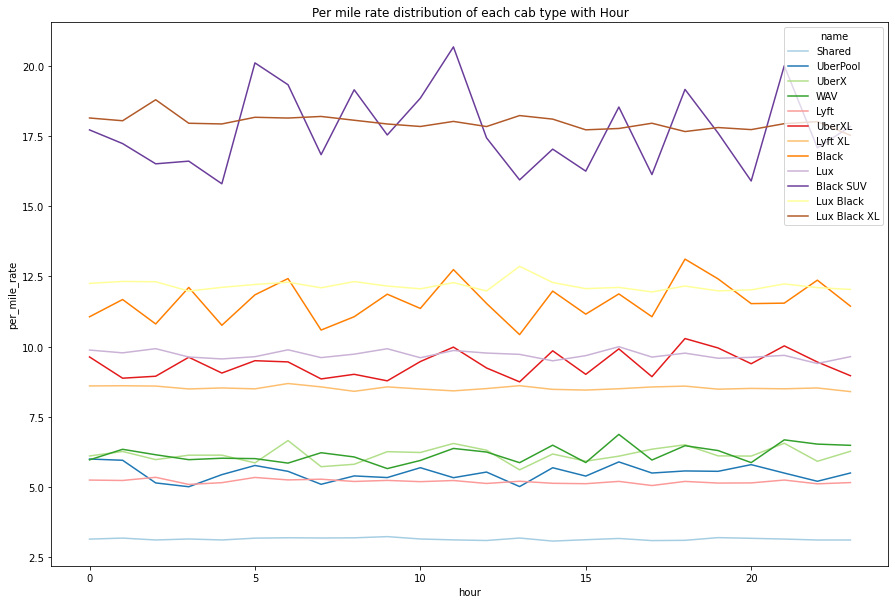

In [ ]:
#Per mile rate
cabtype_df_d = cab_df_pd.groupby(["hour","per_mile_rate","name"]).size().reset_index()
plt.figure(figsize=(15, 10))
sns.lineplot(x="hour", y="per_mile_rate", hue = "name",data=cabtype_df_d,palette="Paired",ci=None).set_title("Per mile rate distribution of each cab type with Hour");

In [ ]:
cabtype_df_d.head()

,hour,per_mile_rate,name,0
0,0,0.634249,Shared,1
1,0,0.659341,Shared,1
2,0,0.660793,Shared,1
3,0,0.662252,Shared,1
4,0,0.665188,Shared,1


Text(0.5, 0, 'Days of the month')

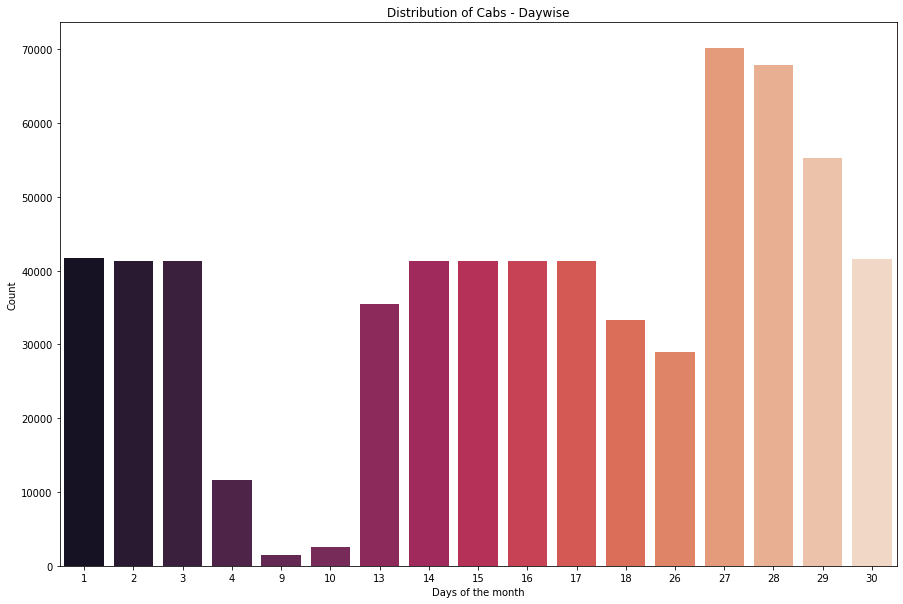

In [ ]:
#Day bar plot

cab_df_day = cab_df_pd.groupby(["day"]).size().reset_index()
#print(cab_df_day)
cab_df_day.columns = ["day", "Count"]
plt.figure(figsize=(15, 10))
sns.barplot(x="day", y="Count", data=cab_df_day,palette="rocket").set_title("Distribution of Cabs - Daywise");
plt.xlabel("Days of the month")

Text(0.5, 0, 'Hour of the day')

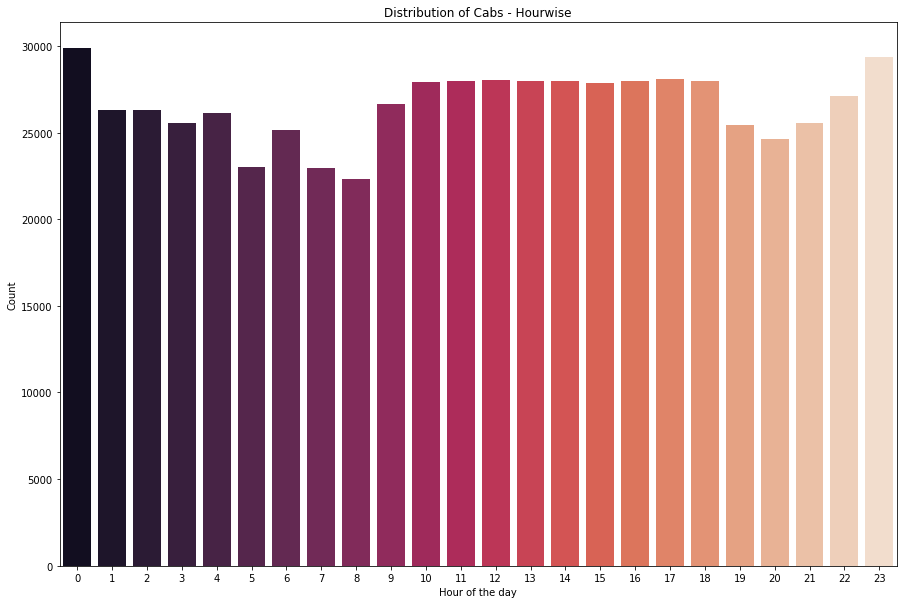

In [ ]:
#Hour bar plot

cab_df_hour = cab_df_pd.groupby(["hour"]).size().reset_index()
#print(cab_df_hour)
cab_df_hour.columns = ["hour", "Count"]
plt.figure(figsize=(15, 10))
sns.barplot(x="hour", y="Count", data=cab_df_hour,palette="rocket").set_title("Distribution of Cabs - Hourwise");
plt.xlabel("Hour of the day")

In [ ]:
#Map and reduce functions to get the source names and their respective counts
def ret_source(x):
  return (x[3],1)
def source_count(val1,val2):
  return (val1+val2)
source_count = cab_df.rdd.map(ret_source).reduceByKey(source_count).toDF()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 1080x720 with 0 Axes>

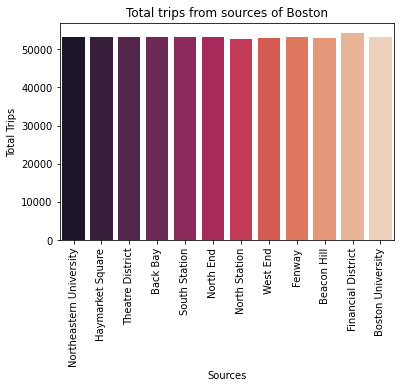

<Figure size 1080x720 with 0 Axes>

In [ ]:
#Checking which sources are popular for the trips by Uber and Lyft
sns.barplot(source_count.toPandas()["_1"],source_count.toPandas()["_2"],palette="rocket")
plt.xticks(rotation=90)
plt.xlabel("Sources")
plt.ylabel("Total Trips")
plt.title("Total trips from sources of Boston")
plt.figure(figsize=(15, 10))

In [ ]:
#Map and reduce functions to get the destination names and their respective counts
def ret_destination(x):
  return (x[2],1)
def destination_count(val1,val2):
  return (val1+val2)

destination_count = cab_df.rdd.map(ret_destination).reduceByKey(destination_count).toDF()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 1080x720 with 0 Axes>

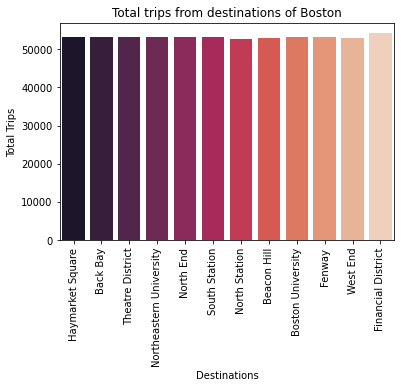

<Figure size 1080x720 with 0 Axes>

In [ ]:
#Checking which destinations are popular for the trips by Uber and Lyft
sns.barplot(destination_count.toPandas()["_1"],destination_count.toPandas()["_2"],palette="rocket")
plt.xticks(rotation=90)
plt.xlabel("Destinations")
plt.ylabel("Total Trips")
plt.title("Total trips from destinations of Boston")
plt.figure(figsize=(15, 10))

Text(0.5, 0, 'Cab Companies')

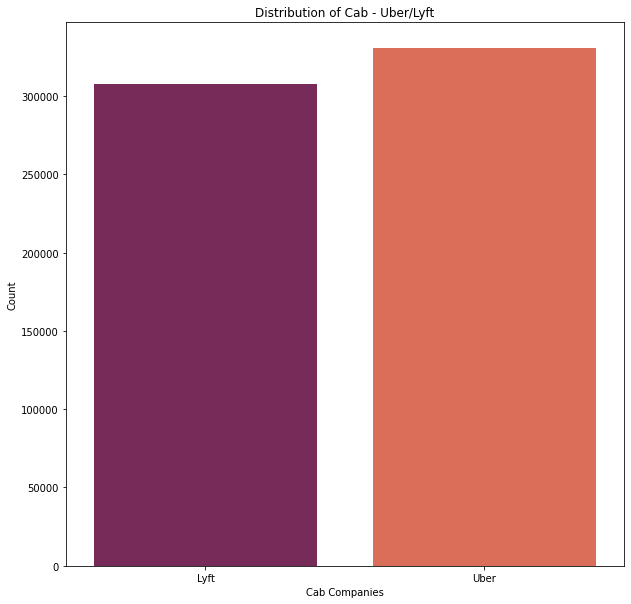

In [ ]:
#Cab Type bar plot

cab_df_type = cab_df_pd.groupby(["cab_type"]).size().reset_index()
#print(cab_df_type)
cab_df_type.columns = ["cab_type", "Count"]
plt.figure(figsize=(10, 10))
sns.barplot(x="cab_type", y="Count", data=cab_df_type,palette="rocket").set_title("Distribution of Cab - Uber/Lyft");
plt.xlabel("Cab Companies")

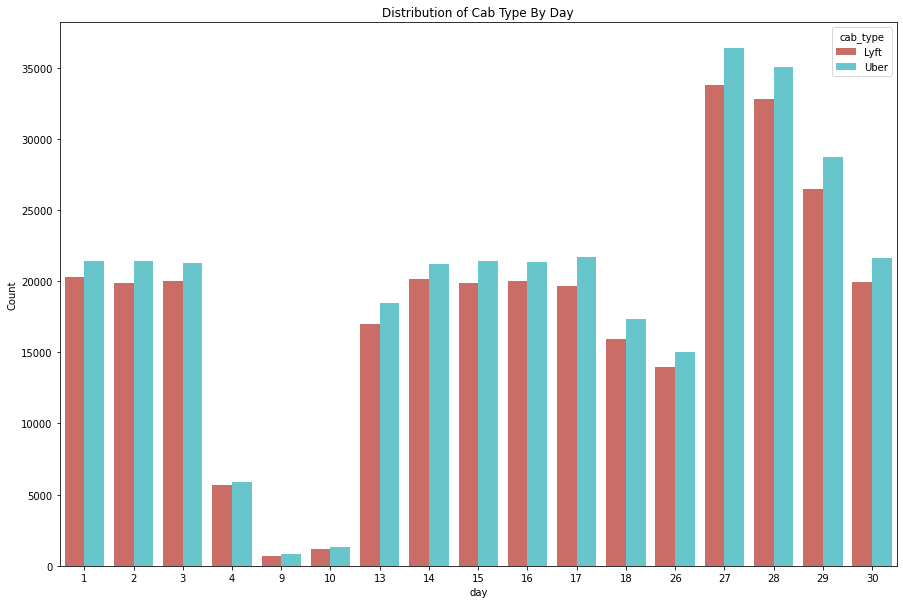

In [ ]:
#Cab Type bar plot
cabtype_df_day = cab_df_pd.groupby(["cab_type","day"]).size().reset_index()
#print(cabtype_df_day)
cabtype_df_day.columns = ["cab_type","day","Count"]
plt.figure(figsize=(15, 10))
sns.barplot(x="day", y="Count", hue = "cab_type",data=cabtype_df_day,palette="hls").set_title("Distribution of Cab Type By Day");

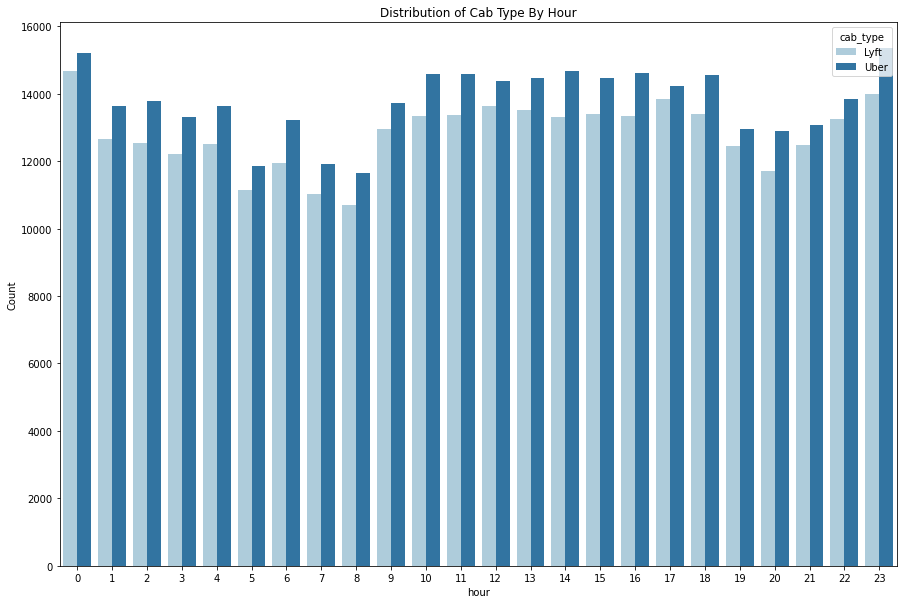

In [ ]:
#Cab Type bar plot

cabtype_df_day = cab_df_pd.groupby(["cab_type","hour"]).size().reset_index()
#print(cabtype_df_day)
cabtype_df_day.columns = ["cab_type","hour","Count"]
plt.figure(figsize=(15, 10))
sns.barplot(x="hour", y="Count", hue = "cab_type",data=cabtype_df_day,palette="Paired").set_title("Distribution of Cab Type By Hour");

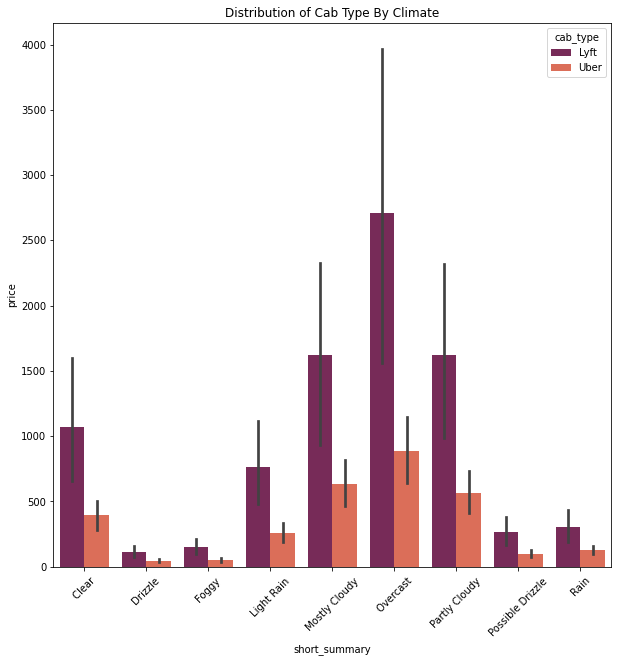

In [ ]:
cabtype_df_day = cab_df_pd.groupby(["cab_type","short_summary","price"]).size().reset_index()
#print(cabtype_df_day)
cabtype_df_day.columns = ["cab_type","short_summary","Count","price"]
plt.figure(figsize=(10, 10))
plt.xticks(rotation=45)
sns.barplot(x="short_summary", y="price", hue = "cab_type",data=cabtype_df_day,palette="rocket").set_title("Distribution of Cab Type By Climate");

In [ ]:
cab_df_pd.head()

,hour,day,source,destination,cab_type,name,price,distance,surge_multiplier,latitude,...,cloudCover,uvIndex,ozone,moonPhase,precipIntensityMax,temperatureMin,temperatureMax,apparentTemperatureMin,apparentTemperatureMax,per_mile_rate
0,9,16,Haymarket Square,North Station,Lyft,Shared,5.0,0.44,1.0,42.2148,...,0.72,0,303.8,0.30,0.1276,39.89,43.68,33.73,38.07,11.363636
1,2,27,Haymarket Square,North Station,Lyft,Lux,11.0,0.44,1.0,42.2148,...,1.00,0,291.1,0.64,0.1300,40.49,47.30,36.20,43.92,25.000000
2,1,28,Haymarket Square,North Station,Lyft,Lyft,7.0,0.44,1.0,42.2148,...,0.03,0,315.7,0.68,0.1064,35.36,47.55,31.04,44.12,15.909091
3,4,30,Haymarket Square,North Station,Lyft,Lux Black XL,26.0,0.44,1.0,42.2148,...,0.00,0,291.1,0.75,0.0000,34.67,45.03,30.30,38.53,59.090909
4,3,29,Haymarket Square,North Station,Lyft,Lyft XL,9.0,0.44,1.0,42.2148,...,0.44,0,347.7,0.72,0.0001,33.10,42.18,29.11,35.75,20.454545


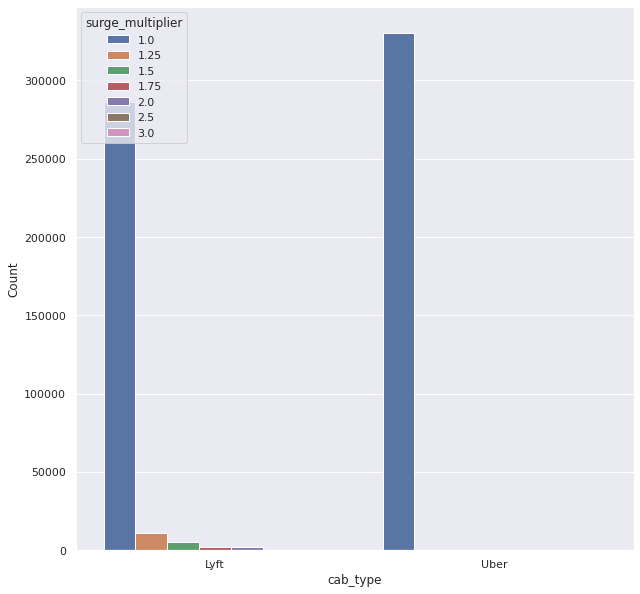

In [ ]:


cab_dfplot1 = cab_df_pd.groupby(["cab_type","surge_multiplier"]).size().reset_index()
cab_dfplot1.columns = ["cab_type","surge_multiplier","Count"]
plot = sns.set(rc = {'figure.figsize':(10,10)})
plot = sns.barplot(x="cab_type", y="Count", hue="surge_multiplier", data=cab_dfplot1)

In [ ]:
cab_uber_df = cab_df.filter(cab_df.cab_type == "Uber")

In [ ]:
cab_uber_df.show()

+----+---+-------------+-------------+--------+---------+-----+--------+----------------+--------+---------+-----------+-------------------+------------------+--------------------+---------------+-----------------+--------+---------+--------+----------+---------------+--------------+-----------------------+---------------------------+----------------------+--------------------------+--------+--------+-----------+----------+-------+-----+---------+------------------+--------------+--------------+----------------------+----------------------+------------------+
|hour|day|       source|  destination|cab_type|     name|price|distance|surge_multiplier|latitude|longitude|temperature|apparentTemperature|     short_summary|        long_summary|precipIntensity|precipProbability|humidity|windSpeed|windGust|visibility|temperatureHigh|temperatureLow|apparentTemperatureHigh|apparentTemperatureHighTime|apparentTemperatureLow|apparentTemperatureLowTime|dewPoint|pressure|windBearing|cloudCover|uvIndex

In [ ]:
print("Shape of Cab Dataframe :",cab_uber_df.count()," , ",len(cab_uber_df.columns))

Shape of Cab Dataframe : 330568  ,  40


#SPLITTING THE DATA

In [ ]:
cab_uber_df.toPandas().to_csv("Uber.csv")

In [ ]:
cab_lyft_df = cab_df.filter(cab_df.cab_type == "Lyft")

In [ ]:
cab_lyft_df

DataFrame[hour: int, day: int, source: string, destination: string, cab_type: string, name: string, price: double, distance: double, surge_multiplier: double, latitude: double, longitude: double, temperature: double, apparentTemperature: double, short_summary: string, long_summary: string, precipIntensity: double, precipProbability: double, humidity: double, windSpeed: double, windGust: double, visibility: double, temperatureHigh: double, temperatureLow: double, apparentTemperatureHigh: double, apparentTemperatureHighTime: int, apparentTemperatureLow: double, apparentTemperatureLowTime: int, dewPoint: double, pressure: double, windBearing: int, cloudCover: double, uvIndex: int, ozone: double, moonPhase: double, precipIntensityMax: double, temperatureMin: double, temperatureMax: double, apparentTemperatureMin: double, apparentTemperatureMax: double, per_mile_rate: double]

In [ ]:
print("Shape of Cab Dataframe :",cab_lyft_df.count()," , ",len(cab_lyft_df.columns))

Shape of Cab Dataframe : 307408  ,  40


In [ ]:
cab_lyft_df.toPandas().to_csv("Lyft.csv")

#EXPLORATORY DATA ANALYSIS OF UBER


EDA after split
1. name bar plot
2. distance vs price for each name type - lyft, lyft xl
3. hour vs price for each name type - lyft, lyft xl
4. heat map - temperature
5. heat map - climate
6. distance vs surgemultiplier for each name type - only for lyft
7. hour vs surgemultiplier for each name type - only for lyft
8. surge multiplier histogram
9. hour vs nametype for each name type - lyft, lyft xl
10. time vs price for each source
11. time vs price for each destination
12. hear map - other categorical

In [ ]:
#READING THE UBER CSV

In [ ]:
uber_df = spark.read.option("inferSchema","true").option("header","true").csv("/content/Uber.csv")
uber_df.show(5)

+---+----+---+---------+-----------+--------+---------+-----+--------+----------------+--------+---------+-----------+-------------------+---------------+--------------------+---------------+-----------------+--------+---------+--------+----------+---------------+--------------+-----------------------+---------------------------+----------------------+--------------------------+--------+--------+-----------+----------+-------+-----+---------+------------------+--------------+--------------+----------------------+----------------------+------------------+
|_c0|hour|day|   source|destination|cab_type|     name|price|distance|surge_multiplier|latitude|longitude|temperature|apparentTemperature|  short_summary|        long_summary|precipIntensity|precipProbability|humidity|windSpeed|windGust|visibility|temperatureHigh|temperatureLow|apparentTemperatureHigh|apparentTemperatureHighTime|apparentTemperatureLow|apparentTemperatureLowTime|dewPoint|pressure|windBearing|cloudCover|uvIndex|ozone|moo

In [ ]:
uber_pd_df = uber_df.toPandas()

In [ ]:
uber_pd_df.head()

,_c0,hour,day,source,destination,cab_type,name,price,distance,surge_multiplier,...,cloudCover,uvIndex,ozone,moonPhase,precipIntensityMax,temperatureMin,temperatureMax,apparentTemperatureMin,apparentTemperatureMax,per_mile_rate
0,0,22,30,North End,West End,Uber,UberXL,12.0,1.11,1.0,...,1.00,0,281.8,0.79,0.0003,28.79,42.52,26.41,40.53,10.810811
1,1,10,13,North End,West End,Uber,Black,16.0,1.11,1.0,...,0.03,0,327.3,0.21,0.0001,18.29,33.83,13.79,32.85,14.414414
2,2,19,13,North End,West End,Uber,UberX,7.5,1.11,1.0,...,0.64,0,330.8,0.21,0.0001,18.29,33.83,13.79,32.85,6.756757
3,3,23,16,North End,West End,Uber,WAV,7.5,1.11,1.0,...,1.00,0,325.3,0.30,0.1252,39.22,43.83,33.98,38.38,6.756757
4,4,0,14,North End,West End,Uber,Black SUV,26.0,1.11,1.0,...,0.91,0,326.7,0.21,0.0001,18.29,33.83,13.79,32.85,23.423423


In [ ]:
def time_to_cat(x):
  if x >= 4 and x <= 8:
    return "Early Morning"
  elif x>8 and x <= 12:
    return "Morning"
  elif x>12 and x<= 16:
    return "Afternoon"
  elif x>16 and x <= 20:
    return "Evening"
  elif x>20 and x<=24:
    return "Night"
  else:
    return "Late Night"

uber_pd_df["Time_cat"] = uber_pd_df["hour"].apply(lambda x:time_to_cat(x))
uber_pd_df.head()

,_c0,hour,day,source,destination,cab_type,name,price,distance,surge_multiplier,...,uvIndex,ozone,moonPhase,precipIntensityMax,temperatureMin,temperatureMax,apparentTemperatureMin,apparentTemperatureMax,per_mile_rate,Time_cat
0,0,22,30,North End,West End,Uber,UberXL,12.0,1.11,1.0,...,0,281.8,0.79,0.0003,28.79,42.52,26.41,40.53,10.810811,Night
1,1,10,13,North End,West End,Uber,Black,16.0,1.11,1.0,...,0,327.3,0.21,0.0001,18.29,33.83,13.79,32.85,14.414414,Morning
2,2,19,13,North End,West End,Uber,UberX,7.5,1.11,1.0,...,0,330.8,0.21,0.0001,18.29,33.83,13.79,32.85,6.756757,Evening
3,3,23,16,North End,West End,Uber,WAV,7.5,1.11,1.0,...,0,325.3,0.30,0.1252,39.22,43.83,33.98,38.38,6.756757,Night
4,4,0,14,North End,West End,Uber,Black SUV,26.0,1.11,1.0,...,0,326.7,0.21,0.0001,18.29,33.83,13.79,32.85,23.423423,Late Night


In [ ]:
#1.

uber_df_name = uber_pd_df.groupby(["name"]).size().reset_index()
#print(cab_df_day)
uber_df_name.columns = ["name", "Count"]
uber_df_name.head()
#g = sns.barplot(x="name", y="Count", data=uber_df_name).set_title("Distribution of Cabs - Daywise");

,name,Count
0,Black,55095
1,Black SUV,55096
2,UberPool,55091
3,UberX,55094
4,UberXL,55096


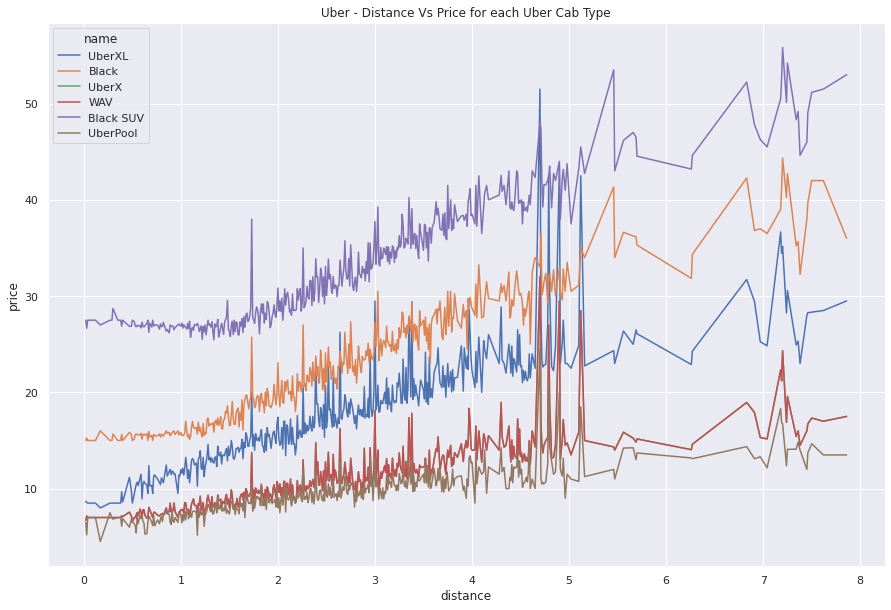

In [ ]:
#2.
uber_dist_price = uber_pd_df[["distance","price","name"]]
plt.figure(figsize=(15, 10))
sns.lineplot(data=uber_dist_price, x="distance", y="price",hue="name",ci=None).set_title("Uber - Distance Vs Price for each Uber Cab Type");

In [ ]:
#4. Doesnt make sense to plot a histogram
uber_pd_df["surge_multiplier"].value_counts()

1.0    330568
Name: surge_multiplier, dtype: int64

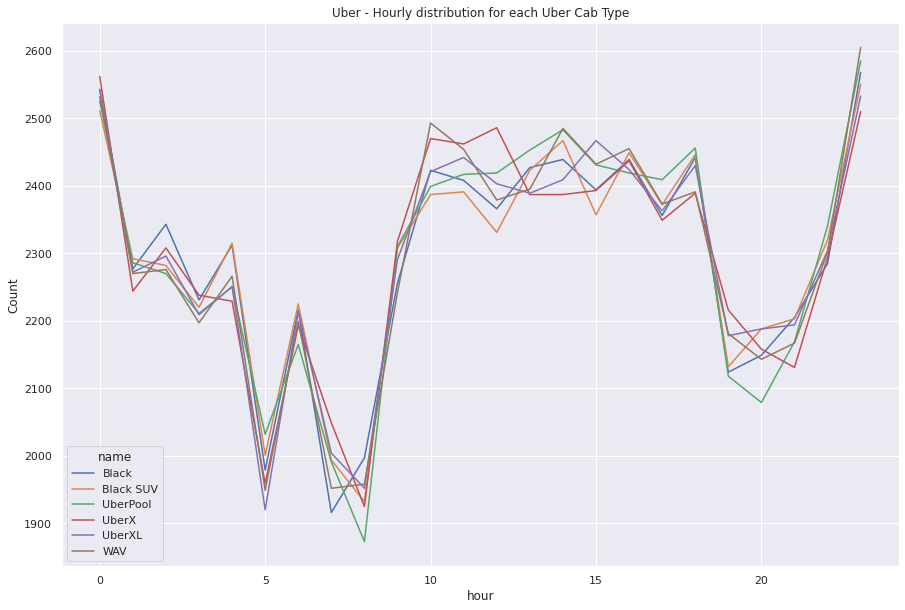

In [ ]:
#5. 

uber_hour = uber_pd_df.groupby(by=["name","hour"]).size().reset_index()
uber_hour.columns = ["name", "hour","Count"]
plt.figure(figsize=(15, 10))
sns.lineplot(x="hour", y="Count",hue="name", data=uber_hour).set_title("Uber - Hourly distribution for each Uber Cab Type");

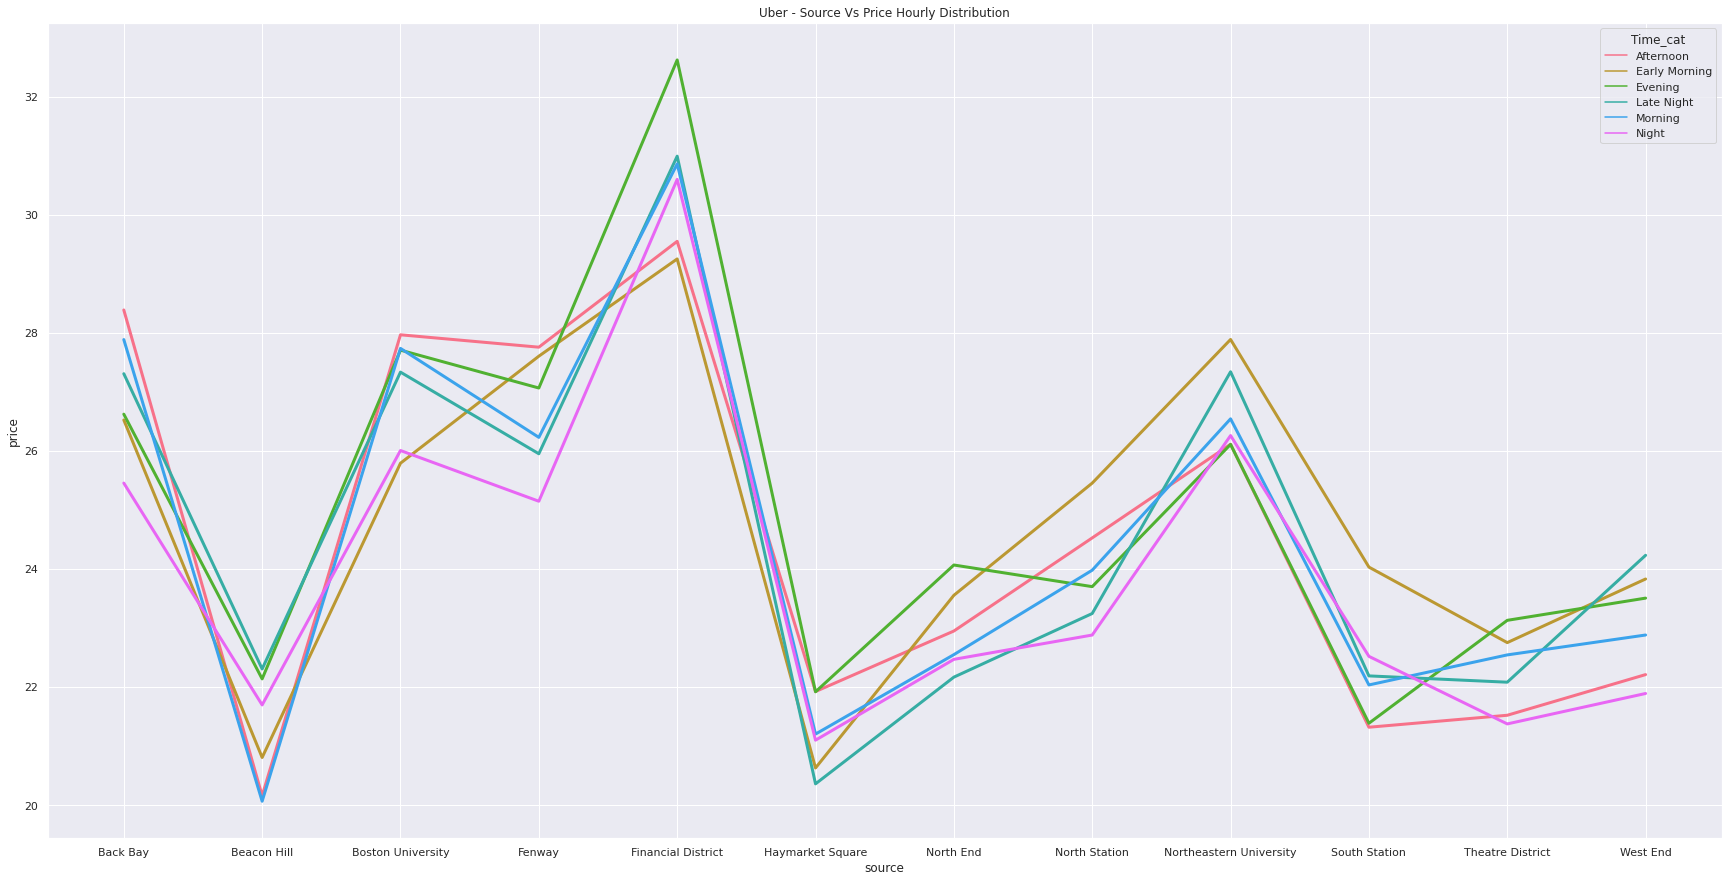

In [ ]:
#6.

uber_source = uber_pd_df.groupby(by=["source","Time_cat","price"]).size().reset_index()
uber_source.columns = ["source","Time_cat","price","Count"]
plt.figure(figsize=(30,15))
sns.lineplot(x="source", y="price",hue="Time_cat", data=uber_source,ci=None, palette="husl",linewidth=3).set_title("Uber - Source Vs Price Hourly Distribution");

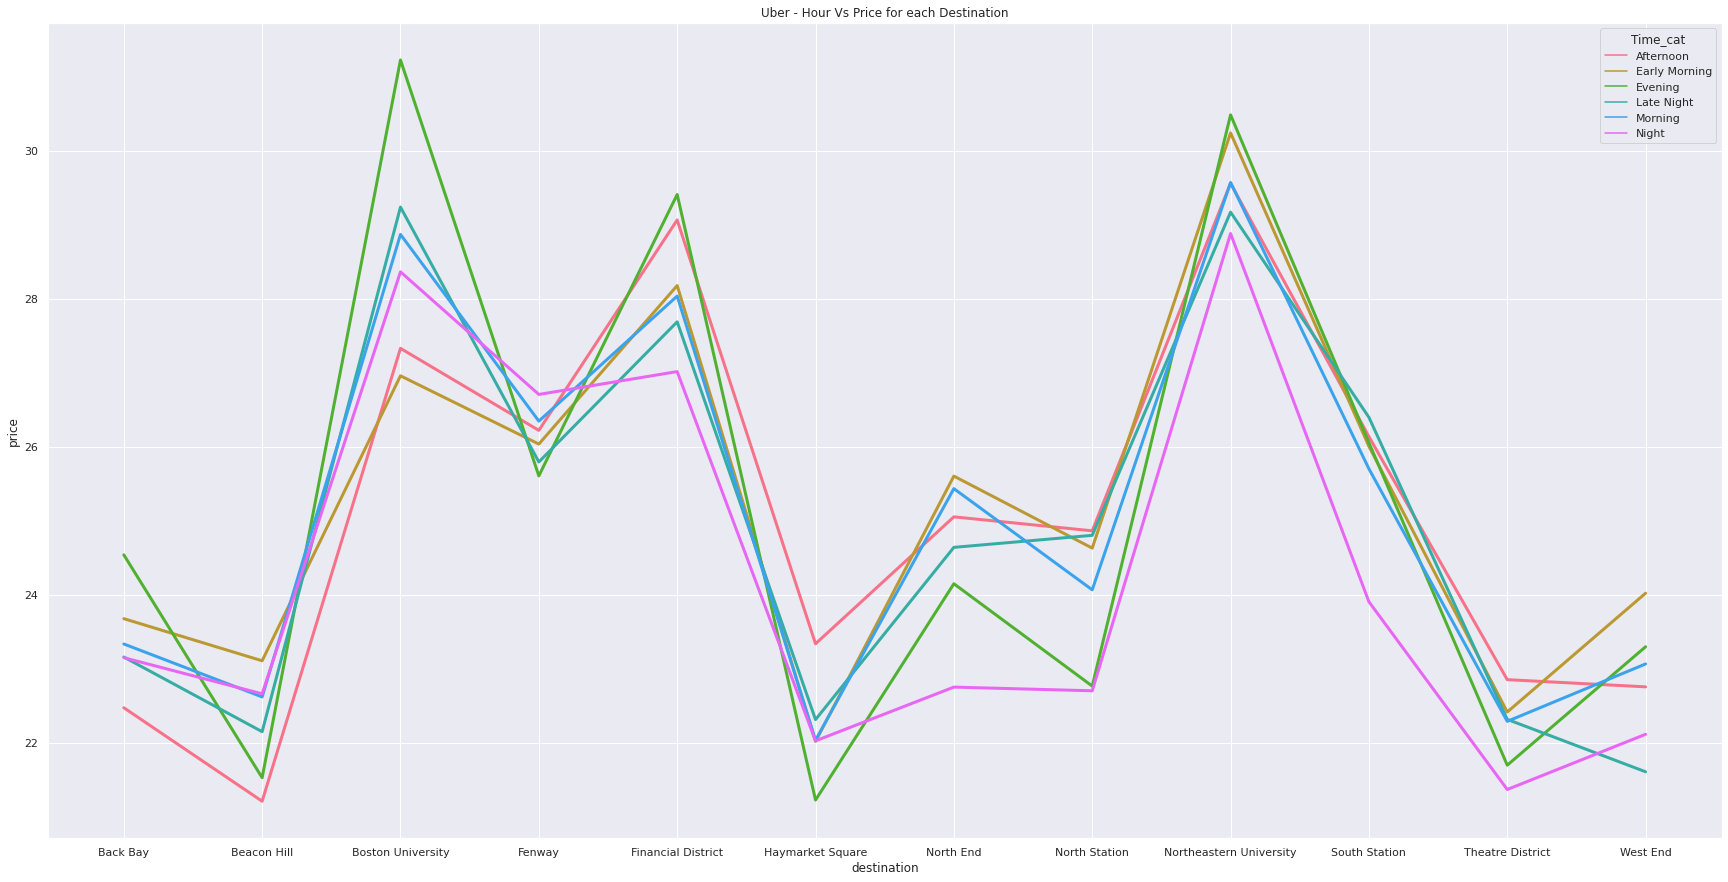

In [ ]:
#6.

uber_dest = uber_pd_df.groupby(by=["destination","Time_cat","price"]).size().reset_index()
uber_dest.columns = ["destination","Time_cat","price","Count"]
plt.figure(figsize=(30,15))
sns.lineplot(x="destination", y="price",hue="Time_cat", data=uber_dest,ci=None, palette="husl",linewidth=3).set_title("Uber - Hour Vs Price for each Destination");

In [ ]:
def time_to_cat(x):
  if x >= 0.02 and x <= 2:
    return "Short Distance"
  elif x>2 and x <= 5:
    return "Medium Distance"
  else:
    return "Long Distance"

uber_pd_df["Dist_cat"] = uber_pd_df["distance"].apply(lambda x:time_to_cat(x))
uber_pd_df.head()

,_c0,hour,day,source,destination,cab_type,name,price,distance,surge_multiplier,...,ozone,moonPhase,precipIntensityMax,temperatureMin,temperatureMax,apparentTemperatureMin,apparentTemperatureMax,per_mile_rate,Time_cat,Dist_cat
0,0,22,30,North End,West End,Uber,UberXL,12.0,1.11,1.0,...,281.8,0.79,0.0003,28.79,42.52,26.41,40.53,10.810811,Night,Short Distance
1,1,10,13,North End,West End,Uber,Black,16.0,1.11,1.0,...,327.3,0.21,0.0001,18.29,33.83,13.79,32.85,14.414414,Morning,Short Distance
2,2,19,13,North End,West End,Uber,UberX,7.5,1.11,1.0,...,330.8,0.21,0.0001,18.29,33.83,13.79,32.85,6.756757,Evening,Short Distance
3,3,23,16,North End,West End,Uber,WAV,7.5,1.11,1.0,...,325.3,0.30,0.1252,39.22,43.83,33.98,38.38,6.756757,Night,Short Distance
4,4,0,14,North End,West End,Uber,Black SUV,26.0,1.11,1.0,...,326.7,0.21,0.0001,18.29,33.83,13.79,32.85,23.423423,Late Night,Short Distance


#EXPLORATORY DATA ANALYSIS OF LYFT

In [ ]:
#READING THE LYFT CSV

In [ ]:
%%bash
wget https://bdadata.s3.amazonaws.com/Lyft-3.csv

--2022-05-05 23:42:59--  https://bdadata.s3.amazonaws.com/Lyft-3.csv
Resolving bdadata.s3.amazonaws.com (bdadata.s3.amazonaws.com)... 54.231.132.177
Connecting to bdadata.s3.amazonaws.com (bdadata.s3.amazonaws.com)|54.231.132.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86777332 (83M) [text/csv]
Saving to: ‘Lyft-3.csv’

     0K .......... .......... .......... .......... ..........  0% 2.42M 34s
    50K .......... .......... .......... .......... ..........  0% 2.52M 33s
   100K .......... .......... .......... .......... ..........  0% 2.54M 33s
   150K .......... .......... .......... .......... ..........  0% 2.49M 33s
   200K .......... .......... .......... .......... ..........  0%  162M 27s
   250K .......... .......... .......... .......... ..........  0%  173M 22s
   300K .......... .......... .......... .......... ..........  0%  175M 19s
   350K .......... .......... .......... .......... ..........  0% 2.58M 21s
   400K .......... ..........

In [ ]:
df = spark.read.option("header", True).option("inferSchema", True).csv("/content/Lyft-3.csv")
df.show(5)

+---+----+---+----------------+-------------+--------+------------+-----+--------+----------------+--------+---------+-----------+-------------------+---------------+--------------------+---------------+-----------------+--------+---------+--------+----------+---------------+--------------+-----------------------+---------------------------+----------------------+--------------------------+--------+--------+-----------+----------+-------+-----+---------+------------------+--------------+--------------+----------------------+----------------------+
|_c0|hour|day|          source|  destination|cab_type|        name|price|distance|surge_multiplier|latitude|longitude|temperature|apparentTemperature|  short_summary|        long_summary|precipIntensity|precipProbability|humidity|windSpeed|windGust|visibility|temperatureHigh|temperatureLow|apparentTemperatureHigh|apparentTemperatureHighTime|apparentTemperatureLow|apparentTemperatureLowTime|dewPoint|pressure|windBearing|cloudCover|uvIndex|ozon

In [ ]:
#dropping unnecessary columns
clean_df = df.drop('_c0','day','apparentTemperatureHighTime','apparentTemperatureLowTime','uvIndex')

In [ ]:
#using hour column to generate time_of_day column and dropping hour column 
hour_list = clean_df.select('hour').rdd.flatMap(lambda x: x).collect()
time_of_day = []
for i in hour_list:
  if hour_list[i] >= 4 and hour_list[i] <=8:
    time_of_day.append("Early Morning")
  elif hour_list[i] > 8 and hour_list[i] <=12:
    time_of_day.append("Morning")
  elif hour_list[i] > 12 and hour_list[i] <=16:
    time_of_day.append("Afternoon")
  elif hour_list[i] > 16 and hour_list[i] <=20:
    time_of_day.append("Evening")
  elif hour_list[i] > 20 and hour_list[i] <= 24:
    time_of_day.append("Night")
  else:
     time_of_day.append("Late Night")

from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window

b = spark.createDataFrame([(l,) for l in time_of_day], ['Time_of_day'])

#adding 'sequential' index and join both dataframe to get the final result
clean_df = clean_df.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
b = b.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))

clean_df = clean_df.join(b, clean_df.row_idx == b.row_idx).\
             drop("row_idx")

clean_df = clean_df.drop('hour')

In [ ]:
clean_df.select('name').distinct().show()

+------------+
|        name|
+------------+
|      Shared|
|         Lux|
|        Lyft|
|Lux Black XL|
|     Lyft XL|
|   Lux Black|
+------------+



In [ ]:
#renaming name column and renaming its categories
clean_df = clean_df.withColumnRenamed('name', 'Cab_category')

In [ ]:
clean_df.show(5)

+----------------+-------------+--------+------------+-----+--------+----------------+--------+---------+-----------+-------------------+---------------+--------------------+---------------+-----------------+--------+---------+--------+----------+---------------+--------------+-----------------------+----------------------+--------+--------+-----------+----------+-----+---------+------------------+--------------+--------------+----------------------+----------------------+-------------+
|          source|  destination|cab_type|Cab_category|price|distance|surge_multiplier|latitude|longitude|temperature|apparentTemperature|  short_summary|        long_summary|precipIntensity|precipProbability|humidity|windSpeed|windGust|visibility|temperatureHigh|temperatureLow|apparentTemperatureHigh|apparentTemperatureLow|dewPoint|pressure|windBearing|cloudCover|ozone|moonPhase|precipIntensityMax|temperatureMin|temperatureMax|apparentTemperatureMin|apparentTemperatureMax|  Time_of_day|
+---------------

In [ ]:
Lyft_pandas = clean_df.toPandas()

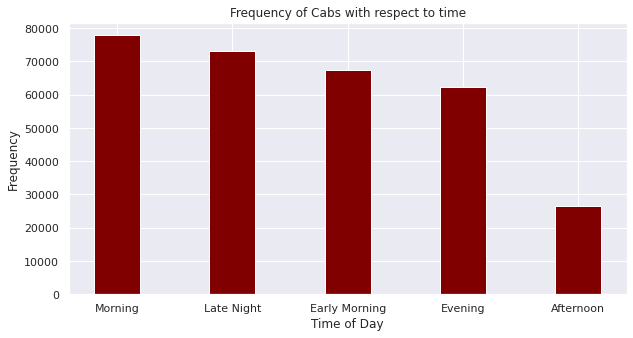

In [ ]:
time_of_day_freq_val = Lyft_pandas['Time_of_day'].value_counts().tolist()
time_of_day_freq_col = Lyft_pandas['Time_of_day'].unique().tolist()

#plot
fig = plt.figure(figsize = (10, 5))
plt.bar(time_of_day_freq_col, time_of_day_freq_val, color ='maroon',
        width = 0.4)
plt.xlabel("Time of Day")
plt.ylabel("Frequency")
plt.title("Frequency of Cabs with respect to time")
plt.show()

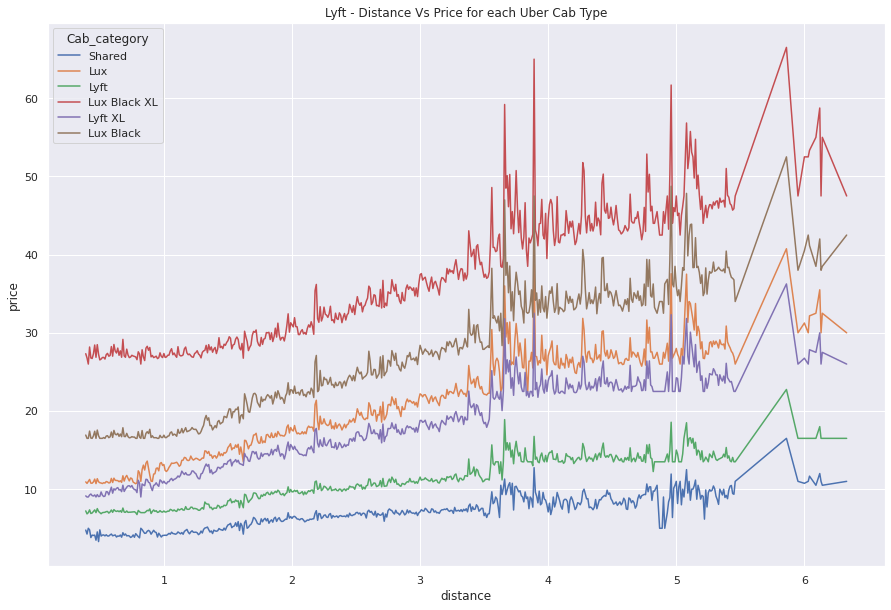

In [ ]:
#2. 
import seaborn as sns
lyft_dist_price = Lyft_pandas[["distance","price","Cab_category"]]
plt.figure(figsize=(15, 10))
sns.lineplot(data=lyft_dist_price, x="distance", y="price",hue="Cab_category",ci=None).set_title("Lyft - Distance Vs Price for each Uber Cab Type");

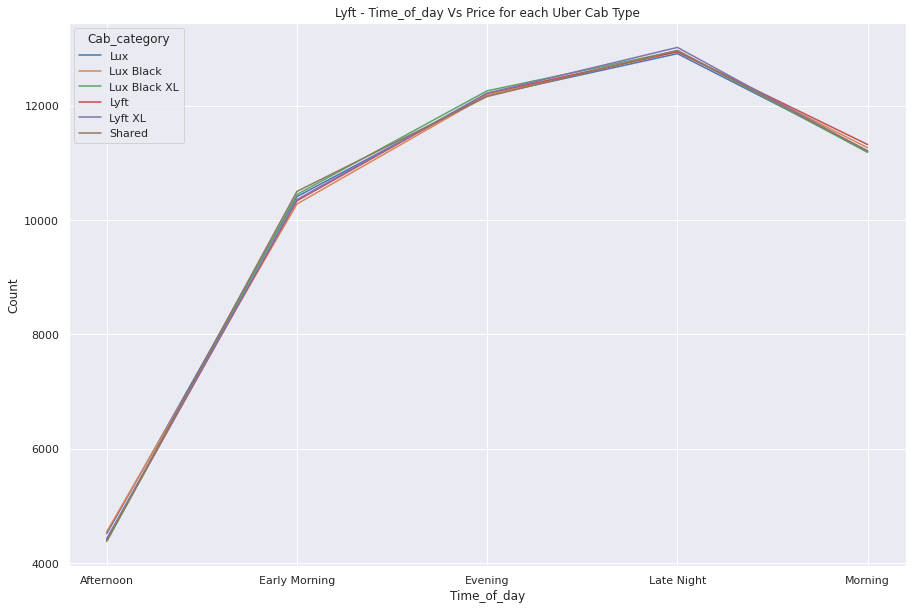

In [ ]:
uber_hour = Lyft_pandas.groupby(by=["Cab_category","Time_of_day"]).size().reset_index()
uber_hour.columns = ["Cab_category", "Time_of_day","Count"]
plt.figure(figsize=(15, 10))
sns.lineplot(x="Time_of_day", y="Count",hue="Cab_category", data=uber_hour).set_title("Lyft - Time_of_day Vs Price for each Uber Cab Type");

In [ ]:
Lyft_pandas.head()

,source,destination,cab_type,Cab_category,price,distance,surge_multiplier,latitude,longitude,temperature,...,windBearing,cloudCover,ozone,moonPhase,precipIntensityMax,temperatureMin,temperatureMax,apparentTemperatureMin,apparentTemperatureMax,Time_of_day
0,Haymarket Square,North Station,Lyft,Shared,5.0,0.44,1.0,42.2148,-71.033,42.34,...,57,0.72,303.8,0.30,0.1276,39.89,43.68,33.73,38.07,Morning
1,Haymarket Square,North Station,Lyft,Lux,11.0,0.44,1.0,42.2148,-71.033,43.58,...,90,1.00,291.1,0.64,0.1300,40.49,47.30,36.20,43.92,Late Night
2,Haymarket Square,North Station,Lyft,Lyft,7.0,0.44,1.0,42.2148,-71.033,38.33,...,240,0.03,315.7,0.68,0.1064,35.36,47.55,31.04,44.12,Late Night
3,Haymarket Square,North Station,Lyft,Lux Black XL,26.0,0.44,1.0,42.2148,-71.033,34.38,...,310,0.00,291.1,0.75,0.0000,34.67,45.03,30.30,38.53,Late Night
4,Haymarket Square,North Station,Lyft,Lyft XL,9.0,0.44,1.0,42.2148,-71.033,37.44,...,303,0.44,347.7,0.72,0.0001,33.10,42.18,29.11,35.75,Early Morning


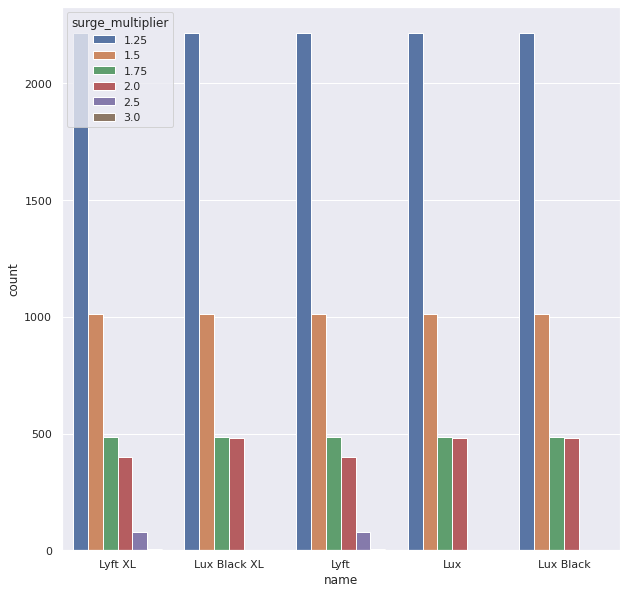

In [ ]:
cab_plot= df.groupBy(["name","surge_multiplier"]).count()
cab_plot = cab_plot.filter('surge_multiplier != 1')
cab_plot = cab_plot.toPandas()

plot = sns.set(rc = {'figure.figsize':(10,10)})
plot = sns.barplot(x="name", y="count", hue="surge_multiplier", data=cab_plot)

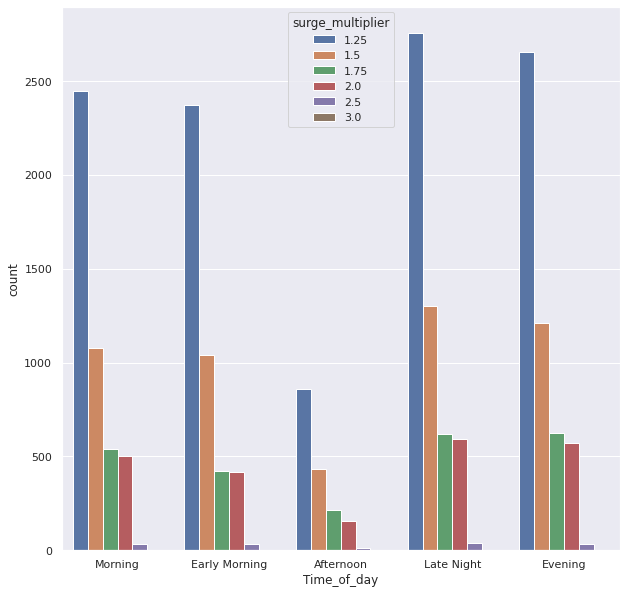

In [ ]:
time_plot= clean_df.groupBy(["Time_of_day","surge_multiplier"]).count()
time_plot = time_plot.filter('surge_multiplier != 1')
time_plot = time_plot.toPandas()

plot = sns.set(rc = {'figure.figsize':(10,10)})
plot = sns.barplot(x="Time_of_day", y="count", hue="surge_multiplier", data=time_plot)

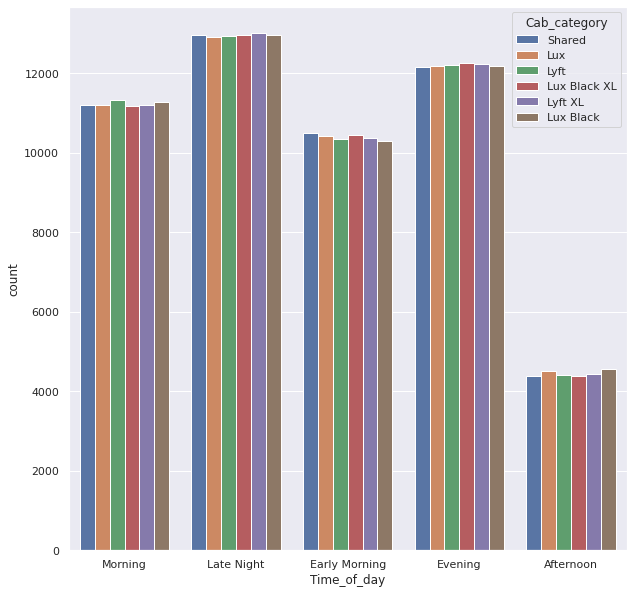

In [ ]:
time_cab= clean_df.groupBy(["Time_of_day","Cab_category"]).count()
time_cab = time_cab.toPandas()

plot = sns.set(rc = {'figure.figsize':(10,10)})
plot = sns.barplot(x="Time_of_day", y="count", hue="Cab_category", data=time_cab)
#cabtype vs time of day
